In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.linear_model import LinearRegression

In [5]:
train = pd.read_csv(r"C:\Users\lrd\Desktop\kaggle\house_price\train.csv")
test = pd.read_csv(r"C:\Users\lrd\Desktop\kaggle\house_price\test.csv")

In [6]:
columns=['Alley','MasVnrType','FireplaceQu','PoolQC','Fence','MiscFeature','Utilities','Street']
train=train.drop(columns,axis=1)
test=test.drop(columns,axis=1)

In [7]:
a=['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','Electrical','GarageType','GarageFinish','GarageQual','GarageCond']
for i in a:
    train[i]=train[i].fillna(train[i].mode()[0])
    test[i]=test[i].fillna(test[i].mode()[0])

c=['MSZoning','Exterior1st','Exterior2nd','KitchenQual','Functional','SaleType']
for i in c:
    test[i]=test[i].fillna(test[i].mode()[0])


In [8]:
b=['LotFrontage','MasVnrArea','GarageYrBlt']
for i in b:
    train[i]=train[i].fillna(train[i].mean())
    test[i]=test[i].fillna(test[i].mean())

d=['BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','GarageCars','GarageArea']
for i in d:
    test[i]=test[i].fillna(test[i].mean())

In [9]:
train['TotalSF']=train['TotalBsmtSF']+train['1stFlrSF']+train['2ndFlrSF']
test['TotalSF']=test['TotalBsmtSF']+test['1stFlrSF']+test['2ndFlrSF']
train['Age']=train['YrSold']-train['YearBuilt']
test['Age']=test['YrSold']-test['YearBuilt']
train['RemodelAge']=train['YearRemodAdd']!=train['YearBuilt'].astype(int)
test['RemodelAge']=test['YearRemodAdd']!=test['YearBuilt'].astype(int)

train=train.drop(['YearBuilt','YearRemodAdd','YrSold','TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1)
test=test.drop(['YearBuilt','YearRemodAdd','YrSold','TotalBsmtSF','1stFlrSF','2ndFlrSF'],axis=1)
train['RemodelAge']=train['RemodelAge'].astype(int)
test['RemodelAge']=test['RemodelAge'].astype(int)

In [10]:
le=LabelEncoder()
for i in train.columns:
    if train[i].dtype=='object':
        train[i]=le.fit_transform(train[i])
for i in test.columns:
    if test[i].dtype=='object':
        test[i]=le.fit_transform(test[i])

In [11]:
train['SalePrice']=np.log1p(train['SalePrice'])

In [12]:
x=train.drop(['SalePrice'],axis=1)
y=train['SalePrice']

In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 定义 KFold 参数
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
params = {
    'booster': 'gbtree',
    'verbosity': 0,
    'nthread': 3,
    'disable_default_eval_metric': 1,
    'eta': 0.1,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 1.,
    'lambda': 3,
    'alpha': 1,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
}

# 交叉验证
rmses = []
for train_index, test_index in kf.split(x):
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # 构建 DMatrix 数据对象
    X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
    X_train = X_train.fillna(X_train.mode())
    X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)
    X_test = X_test.fillna(X_train.mode())
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)
    
    # 训练模型
    model = xgb.train(params,dtrain,num_boost_round=150)
    
    # 预测并计算均方根误差
    y_pred = model.predict(dtest)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmses.append(rmse)

# 输出交叉验证的均方根误差
print("交叉验证的均方根误差：", rmses)
print("均方根误差的平均值：", np.mean(rmses))

交叉验证的均方根误差： [0.14199840771389224, 0.12665318576567636, 0.14058501454225564, 0.1334782764899617, 0.11721507588170056]
均方根误差的平均值： 0.1319859920786973


In [20]:
submission=pd.DataFrame()
submission['Id']=test['Id']
test1 = xgb.DMatrix(test)
final_predictions=model.predict(test1)
final_predictions=np.exp(final_predictions)
submission['SalePrice']=final_predictions
submission.to_csv(r'C:\Users\lrd\Desktop\kaggle\house_price\result.csv',index = False)

<AxesSubplot:>

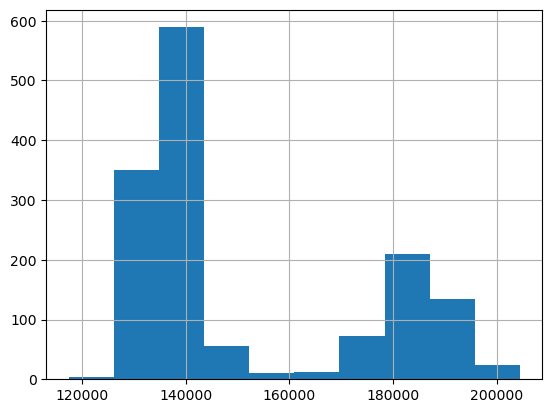

In [19]:
submission['SalePrice'].hist()